<a href="https://colab.research.google.com/github/hmerkle/deepRL/blob/main/New_try_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "gymnasium[accept-rom-license, atari]"
!pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 42.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=f7d04e65edfd41861ab1459a7ddcb6eba014838c364e16f4191418ded4948170
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
   

In [2]:
import tensorflow as tf
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime


In [3]:
class ExperienceReplayBuffer:

    def __init__(self, max_size: int, environment_name: str, parallel_game_unrolls: int, observation_preprocessing_function: callable, unroll_steps:int):
        self.max_size = max_size
        self.environment_name = environment_name
        self.parallel_game_unrolls = parallel_game_unrolls
        self.unroll_steps = unroll_steps
        self.observation_preprocessing_function = observation_preprocessing_function
        self.num_possible_actions = gym.make(environment_name).action_space.n
        self.envs = gym.vector.make(environment_name, num_envs=self.parallel_game_unrolls)
        self.current_states, _ = self.envs.reset()
        self.data = []

    def fill_with_samples(self, dqn_network, epsilon: float):
        # adds new samples into the ERP

        states_list = []
        actions_list = []
        rewards_list = []
        terminateds_list = []
        next_states_list = []


        for i in range(self.unroll_steps):
            actions = self.sample_epsilon_greedy(dqn_network, epsilon) # (PARALLEL_GAME_UNROLLS, )
            # take the action and get s' and r
            next_states, rewards, terminateds, _, _ = self.envs.step(actions)
            # store observation, action, reward, next_observation into ERP container
            #
            states_list.append(self.current_states)
            actions_list.append(actions)
            rewards_list.append(rewards)
            terminateds_list.append(terminateds)
            next_states_list.append(next_states)
            self.current_states = next_states

        def data_generator():
            for states_batch, actions_batch, rewards_batch, terminateds_batch, next_states_batch in \
                zip(states_list, actions_list, rewards_list, terminateds_list, next_states_list):
                for game_idx in range(self.parallel_game_unrolls):
                    state = states_batch[game_idx,:,:,:]
                    action = actions_batch[game_idx]
                    reward = rewards_batch[game_idx]
                    terminated = terminateds_batch[game_idx]
                    next_state = next_states_batch[game_idx,:,:,:]
                    yield(state, action, reward, next_state, terminated)

        dataset_tensor_specs = (tf.TensorSpec(shape=(210,160,3), dtype=tf.uint8),
                                tf.TensorSpec(shape=(), dtype=tf.int32),
                                tf.TensorSpec(shape=(), dtype=tf.float32),
                                tf.TensorSpec(shape=(210,160,3), dtype=tf.uint8),
                                tf.TensorSpec(shape=(), dtype=tf.bool))
        new_samples_dataset = tf.data.Dataset.from_generator(data_generator, output_signature=dataset_tensor_specs)

        new_samples_dataset = new_samples_dataset.map(lambda state, action, reward, next_state, terminated:(self.observation_preprocessing_function(state), action, reward, self.observation_preprocessing_function(next_state), terminated))
        new_samples_dataset = new_samples_dataset.cache().shuffle(buffer_size=self.unroll_steps * self.parallel_game_unrolls, reshuffle_each_iteration=True)

        for elem in new_samples_dataset:
            continue

        self.data.append(new_samples_dataset)

        datapoints_in_data = len(self.data) * self.parallel_game_unrolls * self.unroll_steps
        if datapoints_in_data > self.max_size:
            self.data.pop(0)


    def create_dataset(self):
        ERP_dataset = tf.data.Dataset.sample_from_datasets(self.data, weights=[1/float(len(self.data)) for _ in self.data], stop_on_empty_dataset = False)
        return ERP_dataset

    def sample_epsilon_greedy(self, dqn_network, epsilon):
        observations = self.observation_preprocessing_function(self.current_states)
        q_values = dqn_network(observations) # tensor float 32 shape(parallel_game_unrolls, num_actions)
        greedy_actions = tf.argmax(q_values, axis=1)
        random_actions = tf.random.uniform(shape=(self.parallel_game_unrolls,), minval=0, maxval=self.num_possible_actions, dtype=tf.int64)
        epsilon_sampling = tf.random.uniform(shape=(self.parallel_game_unrolls,), minval=0, maxval=1, dtype=tf.float32) > epsilon
        actions = tf.where(epsilon_sampling, greedy_actions, random_actions).numpy()
        return actions


def observation_preprocessing_function(observation):
    # preprocess our observation so that it has shape (84, 84) and is between -1 and 1
    observation = tf.image.resize(observation, size=(84,84))
    observation = tf.cast(observation, dtype=tf.float32)/128.0 - 1.0
    return observation



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


In [4]:
def create_dqn_model(num_actions: int):
    # create intput for function tf model api
    input_layer = tf.keras.Input(shape=(84,84,3), dtype=tf.float32)

    x1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer) # (84, 84, 3)
    x2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer) + x1 # residual connections
    x3 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer) + x2

    x4 = tf.keras.layers.MaxPool2D(pool_size=2)(x3) # (42, 42, )

    x5 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x4) # (42, 42, )
    x6 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x4) + x5
    x7 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x4) + x6

    x8 = tf.keras.layers.MaxPool2D(pool_size=2)(x7) #(21, 21, )

    x9 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x8) #(21, 21, )
    x10 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x8) + x9
    x11 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x8) + x10

    x12 = tf.keras.layers.MaxPool2D(pool_size=2)(x11) #(10, 10, )

    x13 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x12)
    x14 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x12) + x13
    x15 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x12) + x14

    x16 = tf.keras.layers.GlobalAvgPool2D()(x15)

    x17 = tf.keras.layers.Dense(units=64, activation='relu')(x16) + x16
    x18 = tf.keras.layers.Dense(units=num_actions, activation='linear')(x17)

    model = tf.keras.Model(inputs=input_layer, outputs=x18)

    return model

In [5]:
def train_dqn(train_dqn_network, target_network, dataset, optimizer, gamma: float, num_training_steps: int, batch_size: int=256):
    dataset = dataset.batch(batch_size).prefetch(4)
    @tf.function
    def training_step(q_target, observations, actions):
        with tf.GradientTape() as tape:
            q_predictions_all_actions = train_dqn_network(observations) # shape of q_predictions is (batch_size, num_actions)
            q_predictions = tf.gather(q_predictions_all_actions, actions, batch_dims=1)
            loss = tf.reduce_mean(tf.square(q_predictions - q_target))
        gradients = tape.gradient(loss, train_dqn_network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, train_dqn_network.trainable_variables))
        return loss

    losses = []
    q_values = []
    for i, state_transition in enumerate(dataset):
        state, action, reward, subsequent_state, terminated = state_transition
        # print("shape terminated: ", terminated.shape, terminated)

        # Calculate q_target using the double DQN algorithm
        q_vals_online = train_dqn_network(subsequent_state)
        q_vals_target = target_network(subsequent_state)
        q_values.append(tf.reduce_mean(q_vals_target).numpy())

        # Find the indices of the maximum values in each row of q_vals_online
        max_q_vals_idx_online = tf.argmax(q_vals_online, axis=1)
        # take q values at indices of q_actions_online
        estimated_q_vals = tf.gather(q_vals_target, max_q_vals_idx_online, batch_dims=1)
        # print("shape estimated_q_vals: ", estimated_q_vals.shape, estimated_q_vals)
        use_subsequent_state = tf.where(terminated, tf.zeros_like(estimated_q_vals, dtype=tf.float32), tf.ones_like(estimated_q_vals, dtype=tf.float32))
        q_target = reward + (gamma*estimated_q_vals*use_subsequent_state)

        # Perform training step
        loss = training_step(q_target, observations=state, actions=action).numpy()
        losses.append(loss)

        # q_max_target = tf.reduce_sum(q_vals_target * tf.one_hot(q_actions_online, target_network.output_shape[-1]), axis=1)
        # q_target = tf.where(terminated, reward, reward + gamma * q_max_target)

#         max_q_values = tf.reduce_max(q_vals, axis=1)
#         use_subsequent_state = tf.where(terminated, tf.zeros_like(max_q_values, dtype=tf.float32), tf.ones_like(max_q_values, dtype=tf.float32))
#         q_target = reward + (gamma*max_q_values*use_subsequent_state)

        if i >= num_training_steps:
            break

    return np.mean(losses), np.mean(q_values)

In [6]:
def test_q_network(test_dqn_network, environment_name: str, num_parallel_tests: int, gamma: float, preprocessing_function: callable, test_epsilon: float=0.05):
    envs = gym.vector.make(environment_name, num_parallel_tests)
    num_possible_actions = envs.single_action_space.n
    states, _ = envs.reset()
    done = False
    timestep = 0
    # episodes_finished is np vector of shape (num_parallel_tests,), filled with booleans, starting with all False
    episodes_finished = np.zeros(num_parallel_tests, dtype=bool)
    returns = np.zeros(num_parallel_tests)
    test_steps = 0
    while not done:
        states = preprocessing_function(states)
        q_values_online = test_dqn_network(states)
        greedy_actions = tf.argmax(q_values_online, axis=1) # tensor of type tf.int64, shape (num_parallel_tests,)
        random_actions = tf.random.uniform(shape=(num_parallel_tests, ), minval=0,
                                           maxval=num_possible_actions, dtype=tf.int64)
        epsilon_sampling = tf.random.uniform(shape=(num_parallel_tests,), minval=0,
                                             maxval=1, dtype=tf.float32) > test_epsilon # tensor of type tf.bool, shape (num_parallel_tests,)
        actions = tf.where(epsilon_sampling, greedy_actions, random_actions).numpy() # tensor of type tf.int64, shape (num_parallel_tests,)
        states, rewards, terminateds, _, _ = envs.step(actions)
        # compute pointwise or between episodes_finished and terminateds
        episodes_finished = np.logical_or(episodes_finished, terminateds)
        returns += ((gamma**timestep)*rewards)*(np.logical_not(episodes_finished).astype(np.float32))
        timestep += 1
        # done if all episodes are finished
        done = np.all(episodes_finished)
        test_steps += 1
        # if test_steps % 100 == 0:
        #    print(f"test_steps: {test_steps} {np.sum(episodes_finished)/num_parallel_tests} {terminateds.shape} {episodes_finished.shape}")
    return np.mean(returns)

In [7]:
def visualize_q_values(results_df, step):
    # Create three subplots
    fig, axis = plt.subplots(1, 3, figsize=(12, 4))
    # Include the row indices explicitly in the results_df
    results_df['step'] = results_df.index

    # Plot the average return
    sns.lineplot(x='step', y='average_return', data=results_df, ax=axis[0])
    axis[0].set_xlabel('Step')
    axis[0].set_ylabel('Average Return')
    # Plot the average loss
    sns.lineplot(x='step', y='average_loss', data=results_df, ax=axis[1])
    axis[1].set_xlabel('Step')
    axis[1].set_ylabel('Average Loss')
    # Plot the average Q-values
    sns.lineplot(x='step', y='average_q_values', data=results_df, ax=axis[2])
    axis[2].set_xlabel('Step')
    axis[2].set_ylabel('Average Q-values')

    # Adjust the layout of subplots
    plt.tight_layout()
    # Show the figure
    plt.show()
    # Save the figure
    plt.savefig('figure.png')

    # # save the figure
    # # create a timestring from the timestamp
    # timestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # # save the figure
    # plt.savefig(f"./{timestring}_results_step{step}.png")
    # close the figure


def polyak_averaging_weights(source_network, target_network, polyak_averaging_factor: float):
    source_network_weights = source_network.get_weights()
    target_network_weights = target_network.get_weights()
    averaged_weights = []
    for source_weight, target_weight in zip(source_network_weights, target_network_weights):
        fraction_kept_weights = polyak_averaging_factor * source_weight
        fraction_updated_weights = (1-polyak_averaging_factor) * target_weight
        averaged_weight = fraction_kept_weights + fraction_updated_weights
        averaged_weights.append(averaged_weight)
    target_network.set_weights(averaged_weights)

In [8]:
def dqn():
    ENVIRONMENT_NAME = "ALE/Breakout-v5"
    NUMBER_ACTIONS = gym.make(ENVIRONMENT_NAME).action_space.n
    ERP_SIZE = 3000#10000
    PARALLEL_GAME_UNROLLS = 24#64
    UNROLL_STEPS = 12#24
    EPSILON = 0.2
    GAMMA = 0.98
    NUM_TRAINING_STEPS_PER_ITER = 12#16
    NUM_TRAINING_ITERS = 1000#50000
    TEST_EVERY_N_STEPS = 5#10#1000
    TEST_NUM_PARALLEL_ENVS = 24#48#128
    PREFILL_STEPS = 20#50
    POLYAK_AVERAGING_FACTOR = 0.001
    erp = ExperienceReplayBuffer(max_size=ERP_SIZE, environment_name=ENVIRONMENT_NAME,
                                 parallel_game_unrolls=PARALLEL_GAME_UNROLLS, unroll_steps=UNROLL_STEPS,
                                 observation_preprocessing_function=observation_preprocessing_function)

    # This is the DQN we train
    dqn_agent = create_dqn_model(num_actions=NUMBER_ACTIONS)
    # This is the target network, used to calculate the q-estimation targets
    target_network = create_dqn_model(num_actions=NUMBER_ACTIONS)
    # dqn_agent.summary()
    # test the agent
    # dqn_agent(tf.random.uniform(shape=(1, 84, 84, 3)))
    # copy over the weights from the dqn_agent to the target_network via polyak averaging with factor 0.0
    polyak_averaging_weights(dqn_agent, target_network, polyak_averaging_factor=0.0)

    dqn_optimizer = tf.keras.optimizers.Adam()

    return_tracker = []
    dqn_prediction_error = []
    average_q_values = []

    # prefill the replay buffer
    prefill_exploration_epsilon = 1.
    for prefill_step in range(PREFILL_STEPS):
        erp.fill_with_samples(dqn_agent, epsilon=prefill_exploration_epsilon)

    dfs = []
    for step in range(1, NUM_TRAINING_ITERS+1):
        # print(f'Training step: {step}')
        # step 1: put some s, a, r, s', t transitions into the replay buffer
        erp.fill_with_samples(dqn_agent, epsilon=EPSILON)
        dataset = erp.create_dataset()
        # step 2: train on some samples from the replay buffer
        average_loss, average_q_vals = train_dqn(dqn_agent, target_network, dataset, dqn_optimizer, gamma=GAMMA, num_training_steps=NUM_TRAINING_STEPS_PER_ITER)
        # update the target network via polyak averaging
        polyak_averaging_weights(dqn_agent, target_network, polyak_averaging_factor=POLYAK_AVERAGING_FACTOR)

        if step % TEST_EVERY_N_STEPS == 0:
            print(f'Training step: {step}')
            average_return = test_q_network(dqn_agent, ENVIRONMENT_NAME, num_parallel_tests=TEST_NUM_PARALLEL_ENVS, gamma=GAMMA,
                                            preprocessing_function=observation_preprocessing_function)
            return_tracker.append(average_return)
            dqn_prediction_error.append(average_loss)
            average_q_values.append(average_q_vals)
            # print average returns, average loss, average q values
            print(f"TESTING: Average return: {average_return}, Average loss: {average_loss}, Average q value-estimation: {average_q_vals}")
            # put all result lists into a dataframe by transforming them into a dict first
            results_dict = {'average_return': return_tracker, 'average_loss': dqn_prediction_error, 'average_q_values': average_q_values}
            results_df = pd.DataFrame(results_dict)
            # visualize
            dfs.append(results_df)
            # skip first round for vizualitation as not enough datapoints
            if step != TEST_EVERY_N_STEPS:
              visualize_q_values(results_df, step)
            print(results_df)

    return dfs

Training step: 5
TESTING: Average return: 0.0898179796772639, Average loss: 8.644552230834961, Average q value-estimation: -0.43792733550071716
   average_return  average_loss  average_q_values
0        0.089818      8.644552         -0.437927
Training step: 10
TESTING: Average return: 0.23709943768202432, Average loss: 0.3336608111858368, Average q value-estimation: -0.4349541664123535


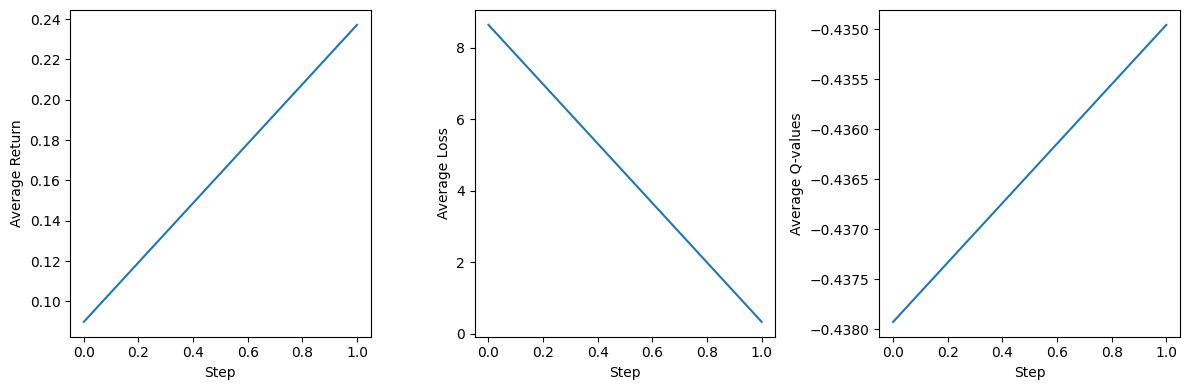

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
Training step: 15
TESTING: Average return: 0.1871556842063209, Average loss: 0.012059093452990055, Average q value-estimation: -0.43216046690940857


<Figure size 640x480 with 0 Axes>

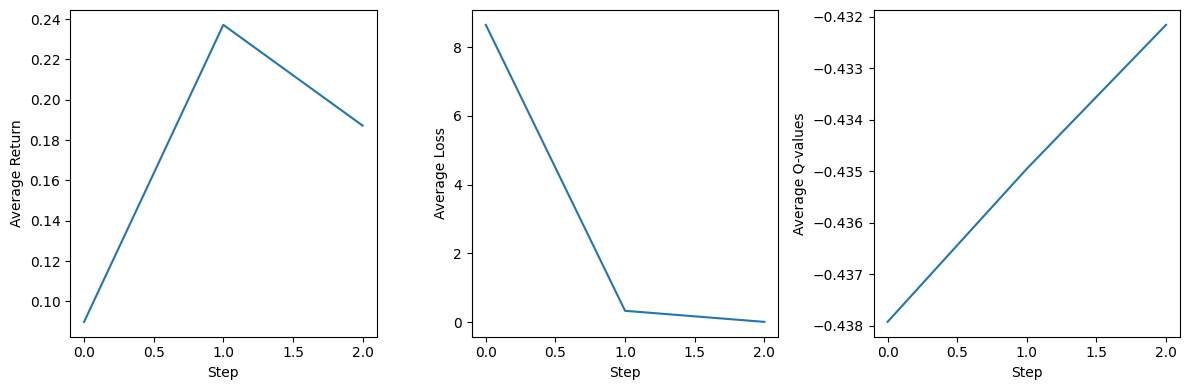

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
Training step: 20
TESTING: Average return: 0.13961025246979764, Average loss: 0.011927686631679535, Average q value-estimation: -0.4294562339782715


<Figure size 640x480 with 0 Axes>

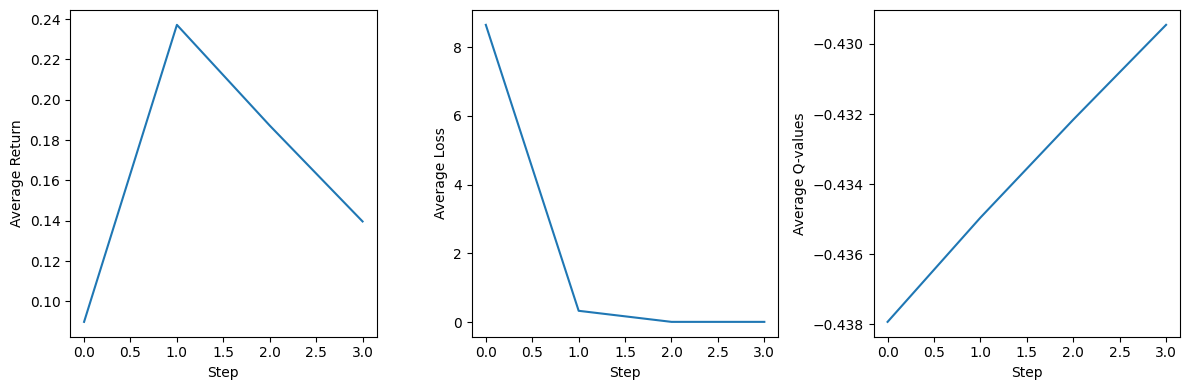

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
Training step: 25
TESTING: Average return: 0.26627493058531576, Average loss: 0.014564747922122478, Average q value-estimation: -0.42522132396698


<Figure size 640x480 with 0 Axes>

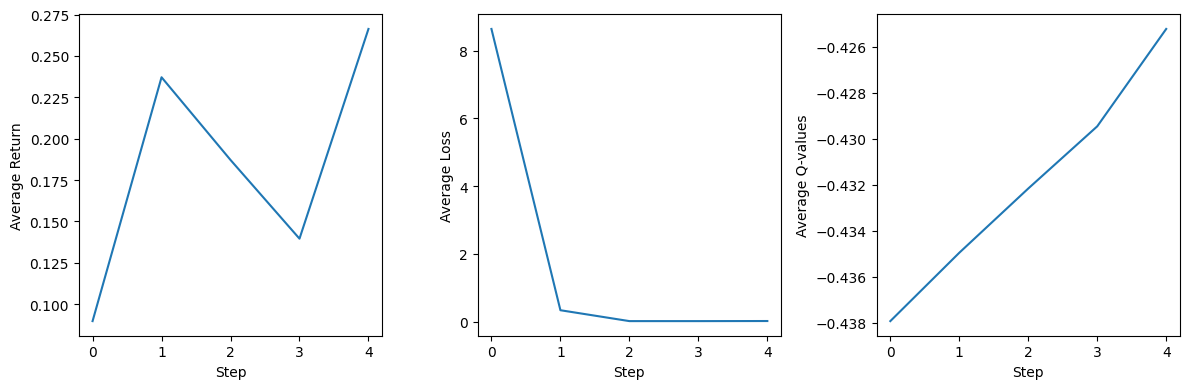

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
4        0.266275      0.014565         -0.425221     4
Training step: 30
TESTING: Average return: 0.12429188937064288, Average loss: 0.018057042732834816, Average q value-estimation: -0.4204850196838379


<Figure size 640x480 with 0 Axes>

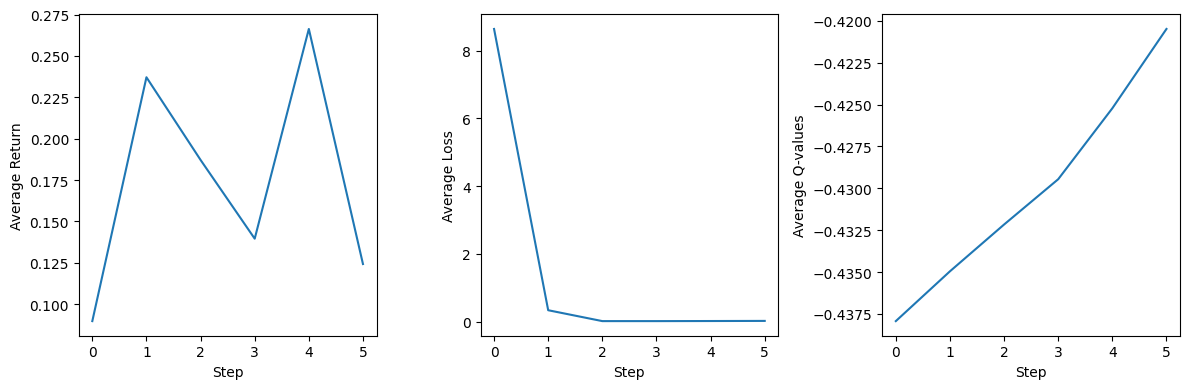

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
4        0.266275      0.014565         -0.425221     4
5        0.124292      0.018057         -0.420485     5
Training step: 35
TESTING: Average return: 0.1877635861765619, Average loss: 0.029075047001242638, Average q value-estimation: -0.41494154930114746


<Figure size 640x480 with 0 Axes>

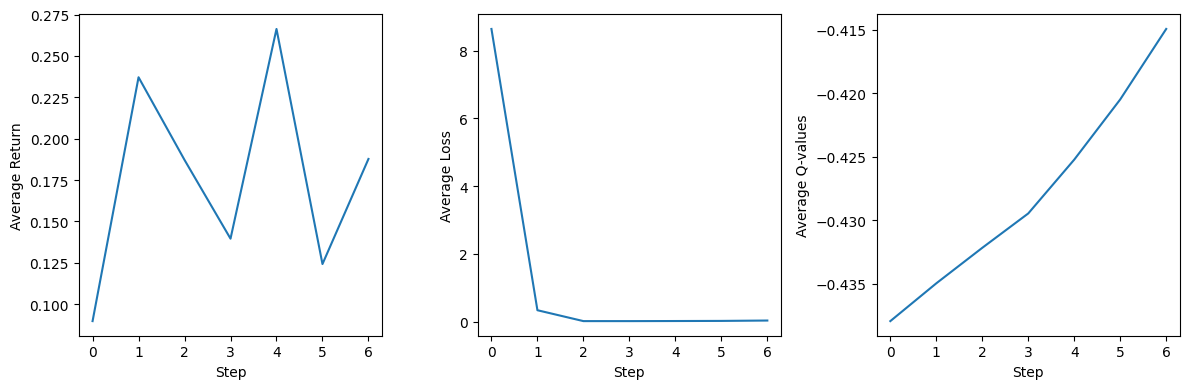

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
4        0.266275      0.014565         -0.425221     4
5        0.124292      0.018057         -0.420485     5
6        0.187764      0.029075         -0.414942     6
Training step: 40
TESTING: Average return: 0.22586286148142273, Average loss: 0.05290282145142555, Average q value-estimation: -0.4077538251876831


<Figure size 640x480 with 0 Axes>

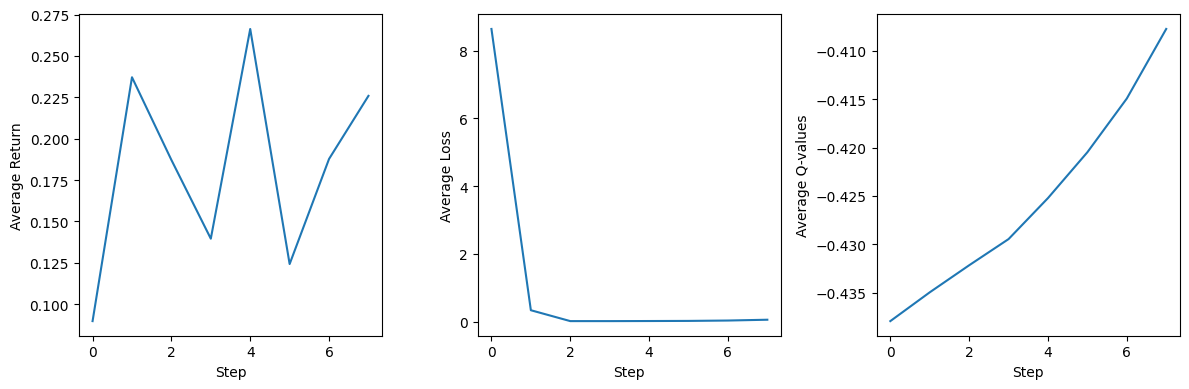

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
4        0.266275      0.014565         -0.425221     4
5        0.124292      0.018057         -0.420485     5
6        0.187764      0.029075         -0.414942     6
7        0.225863      0.052903         -0.407754     7
Training step: 45
TESTING: Average return: 0.13077634090581036, Average loss: 0.03725580871105194, Average q value-estimation: -0.40012064576148987


<Figure size 640x480 with 0 Axes>

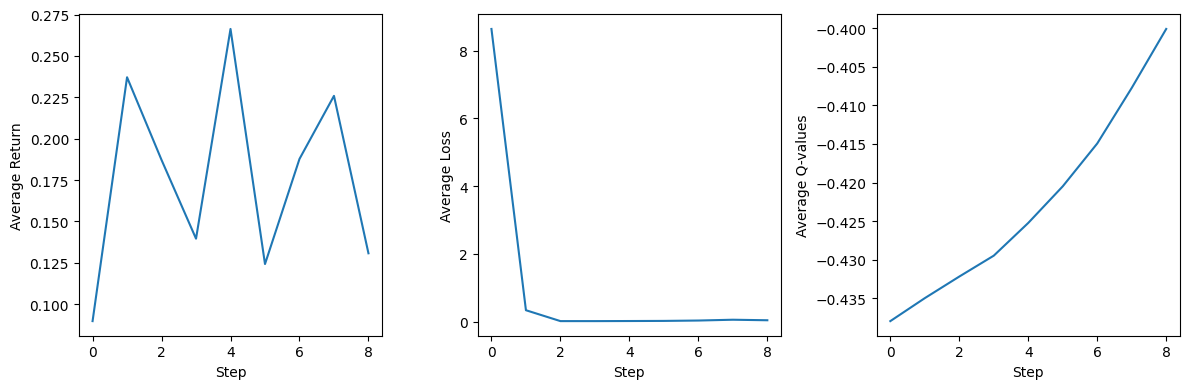

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
4        0.266275      0.014565         -0.425221     4
5        0.124292      0.018057         -0.420485     5
6        0.187764      0.029075         -0.414942     6
7        0.225863      0.052903         -0.407754     7
8        0.130776      0.037256         -0.400121     8
Training step: 50
TESTING: Average return: 0.18564863140379587, Average loss: 0.1028558686375618, Average q value-estimation: -0.39217618107795715


<Figure size 640x480 with 0 Axes>

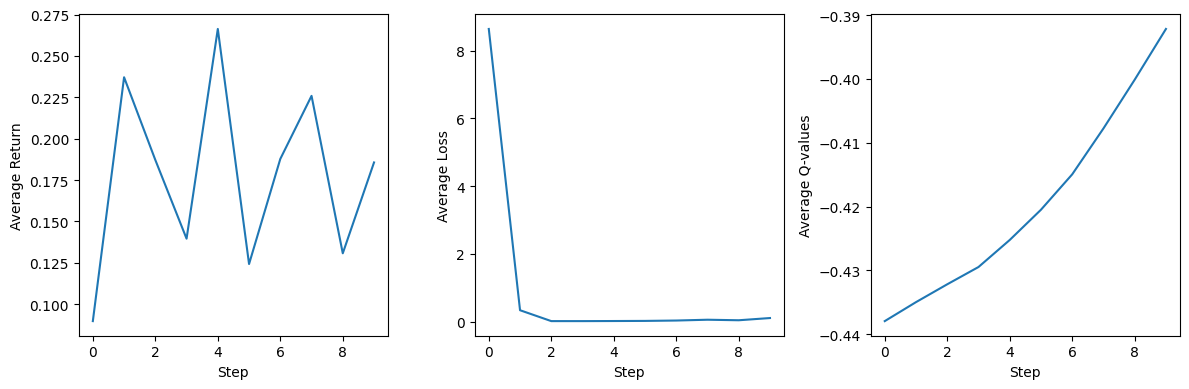

   average_return  average_loss  average_q_values  step
0        0.089818      8.644552         -0.437927     0
1        0.237099      0.333661         -0.434954     1
2        0.187156      0.012059         -0.432160     2
3        0.139610      0.011928         -0.429456     3
4        0.266275      0.014565         -0.425221     4
5        0.124292      0.018057         -0.420485     5
6        0.187764      0.029075         -0.414942     6
7        0.225863      0.052903         -0.407754     7
8        0.130776      0.037256         -0.400121     8
9        0.185649      0.102856         -0.392176     9
Training step: 55
TESTING: Average return: 0.19244628932269905, Average loss: 0.05054974928498268, Average q value-estimation: -0.3823171854019165


<Figure size 640x480 with 0 Axes>

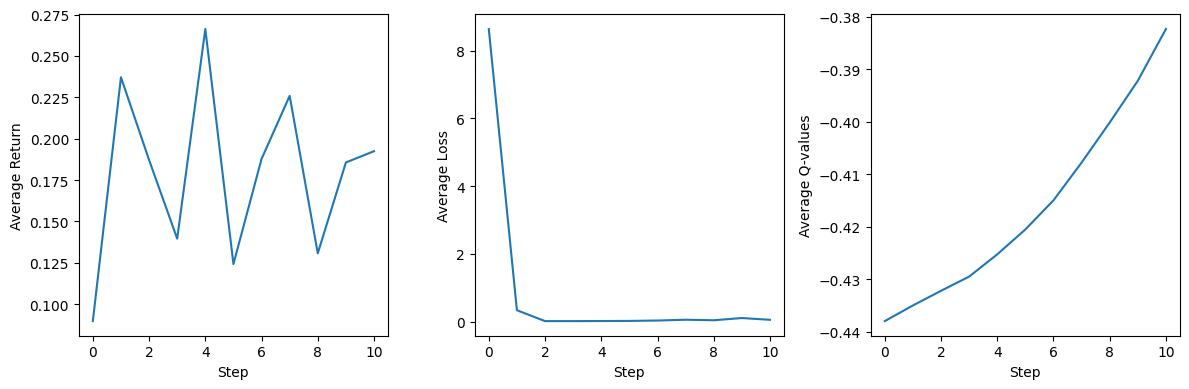

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
Training step: 60
TESTING: Average return: 0.1598808949663368, Average loss: 0.14387035369873047, Average q value-estimation: -0.3725447952747345


<Figure size 640x480 with 0 Axes>

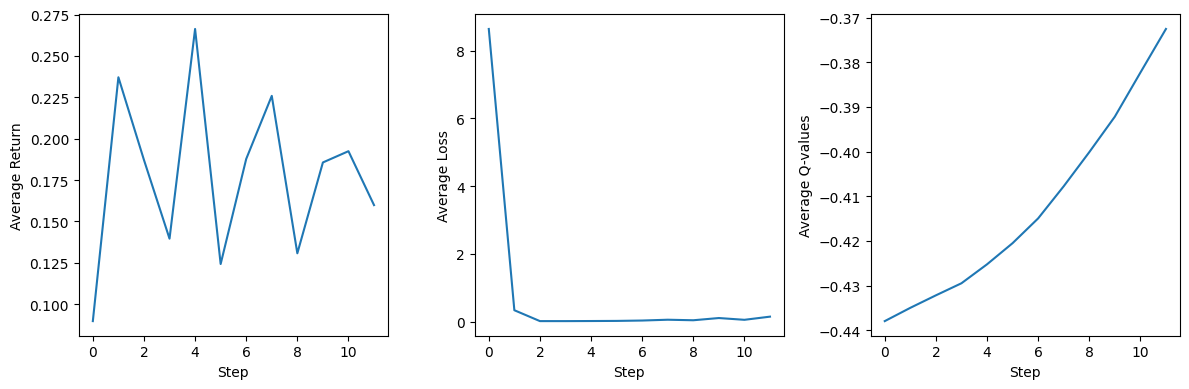

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
Training step: 65
TESTING: Average return: 0.19376309503928554, Average loss: 0.14347632229328156, Average q value-estimation: -0.36436620354652405


<Figure size 640x480 with 0 Axes>

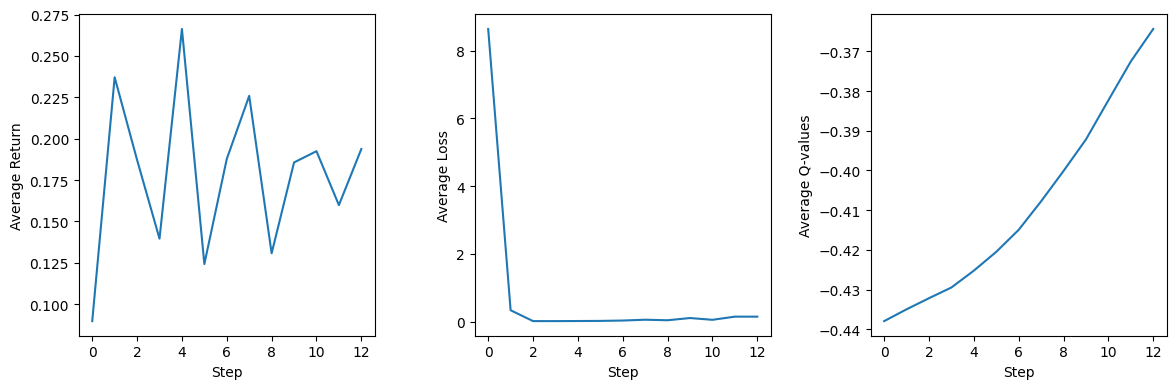

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
Training step: 70
TESTING: Average return: 0.13663006655943113, Average loss: 0.19118380546569824, Average q value-estimation: -0.35536614060401917


<Figure size 640x480 with 0 Axes>

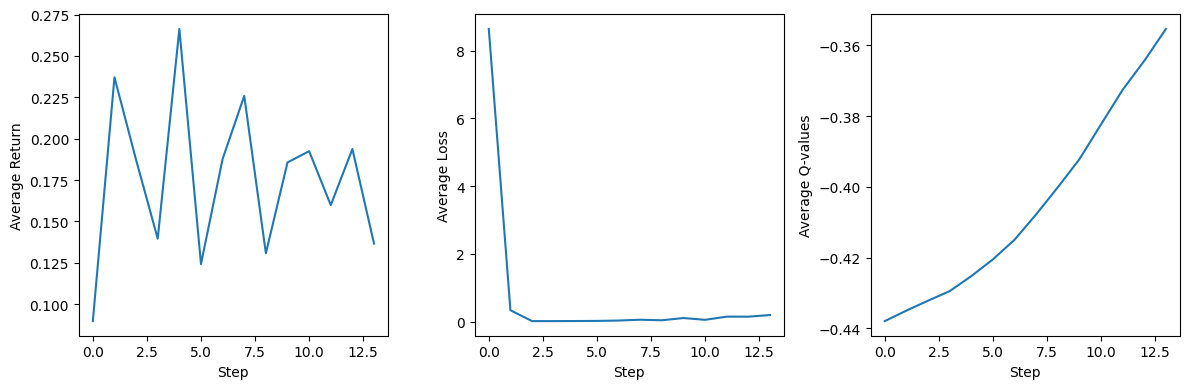

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
Training step: 75
TESTING: Average return: 0.1255201621786989, Average loss: 0.014996656216681004, Average q value-estimation: -0.347480863332748

<Figure size 640x480 with 0 Axes>

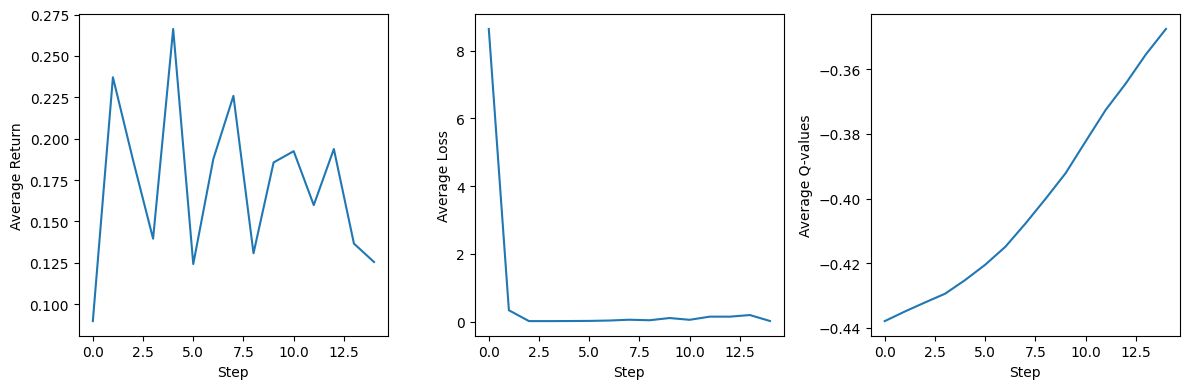

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
Training step: 80
TESTING: Average return: 0.01904705654330618, Average loss: 0.04794936

<Figure size 640x480 with 0 Axes>

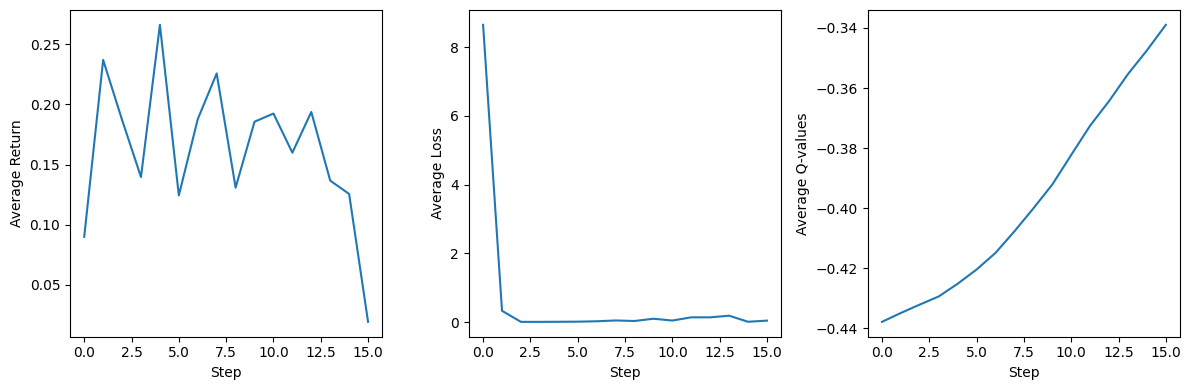

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
Training step: 85
TESTING: Aver

<Figure size 640x480 with 0 Axes>

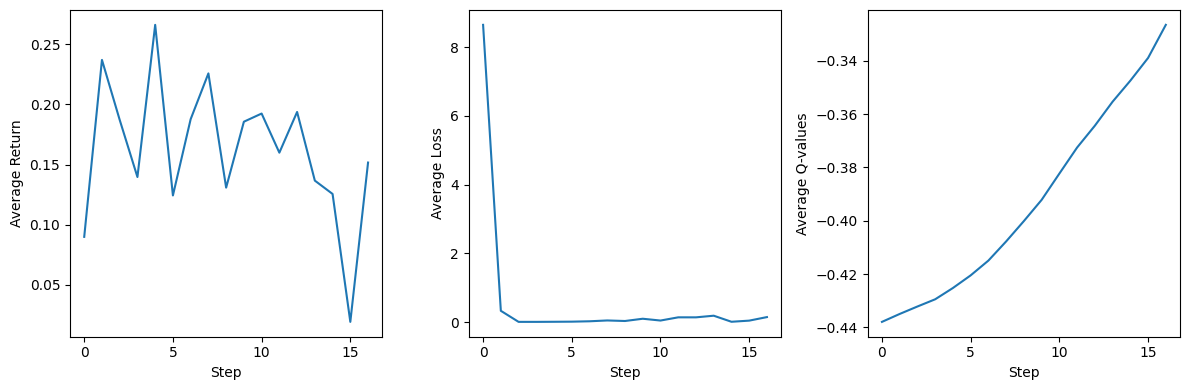

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

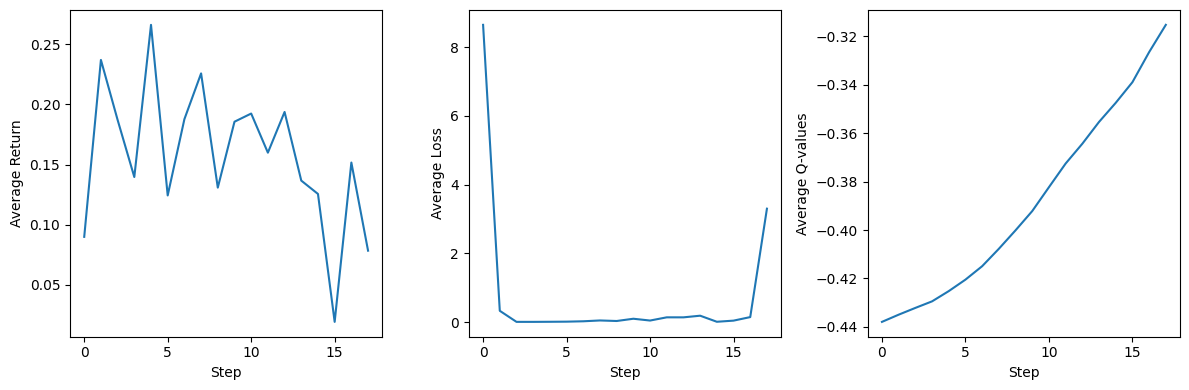

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

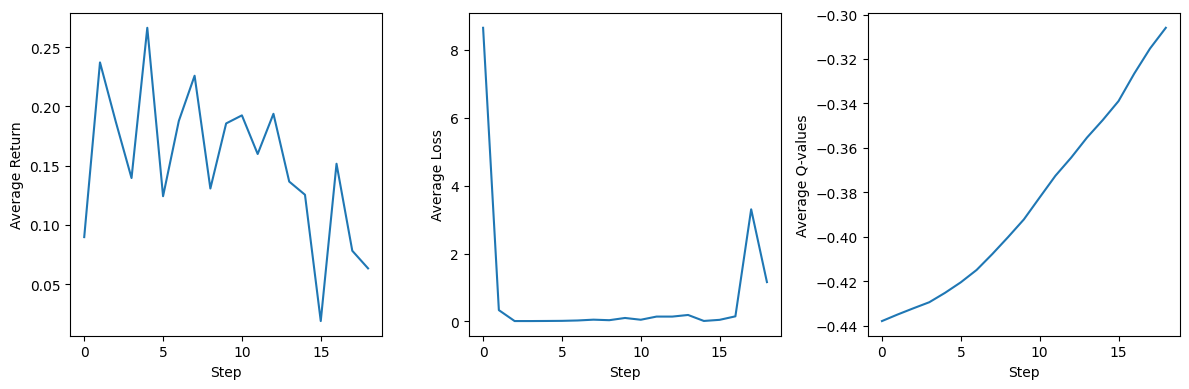

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

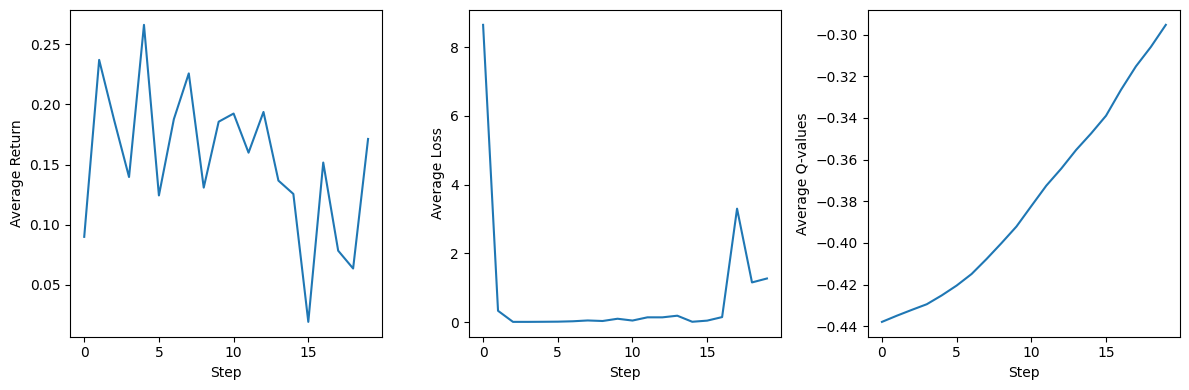

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

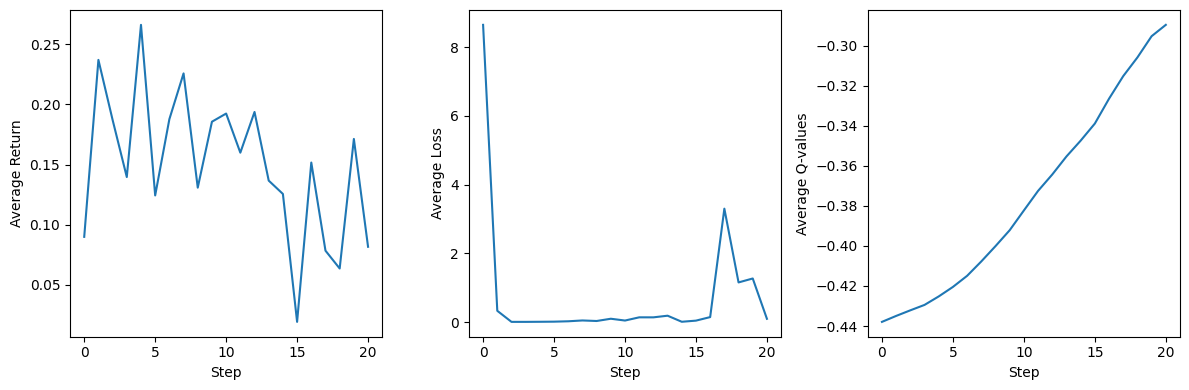

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

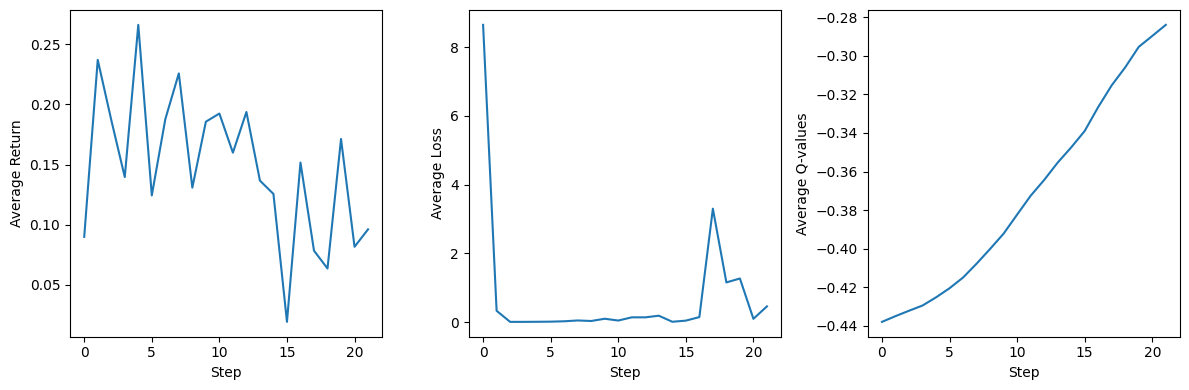

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

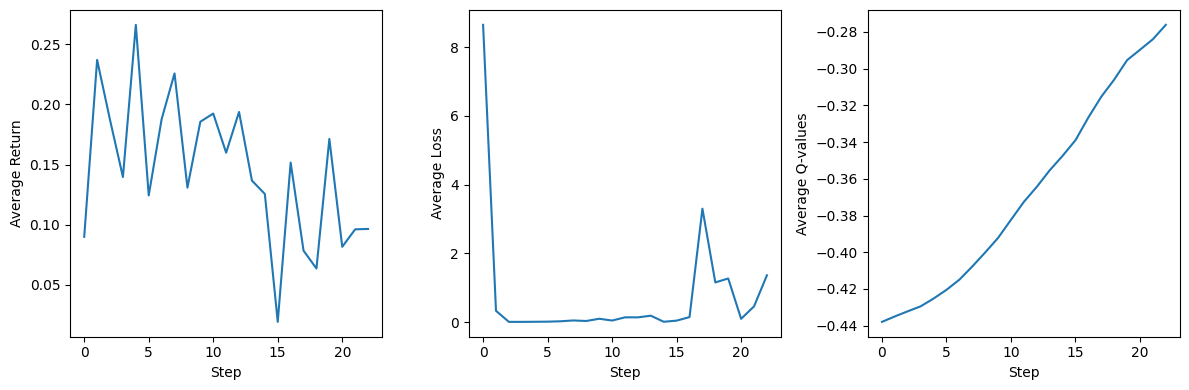

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

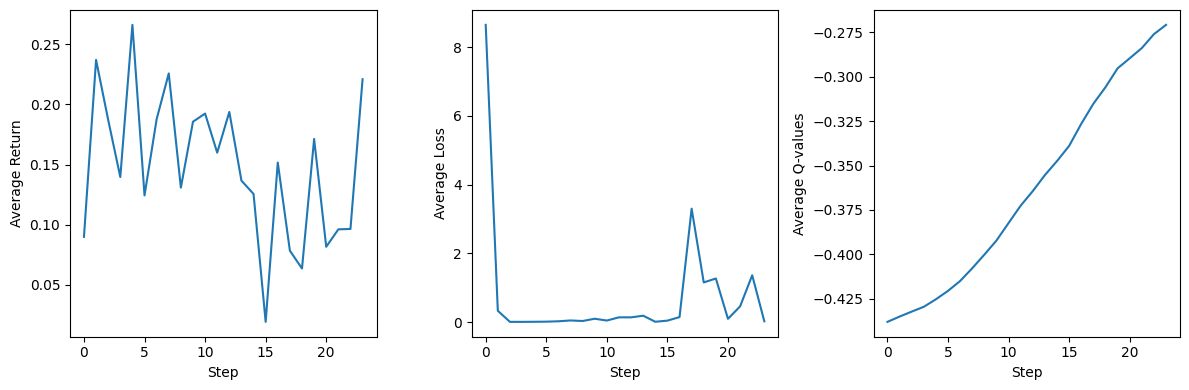

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

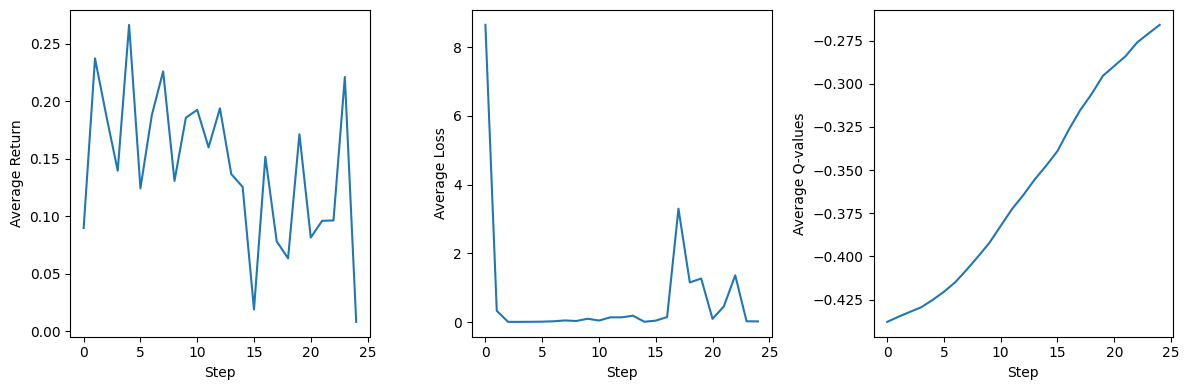

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

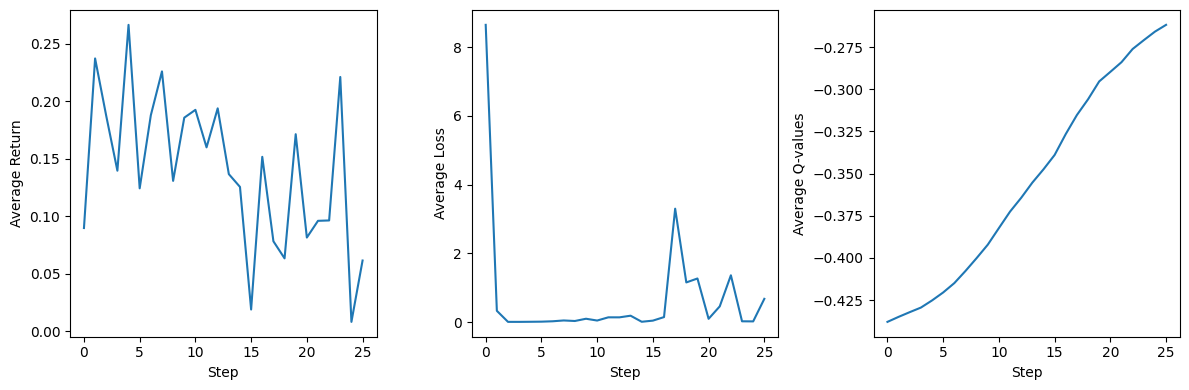

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

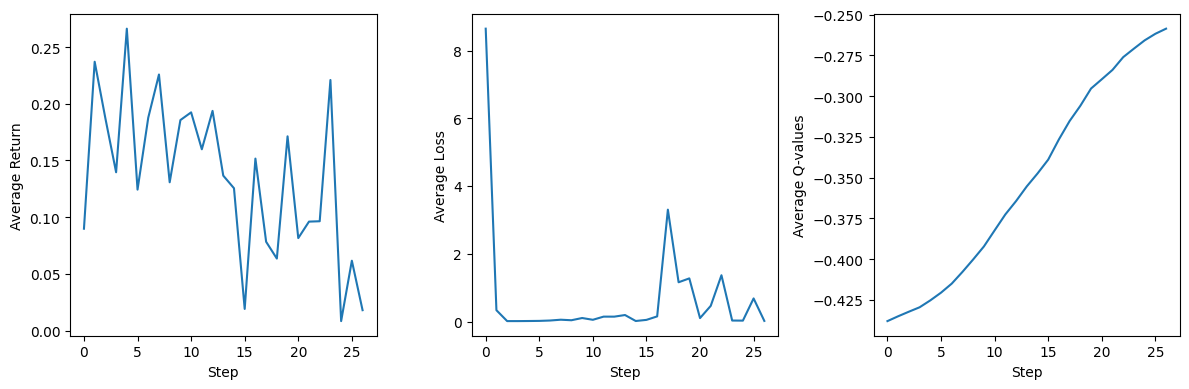

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

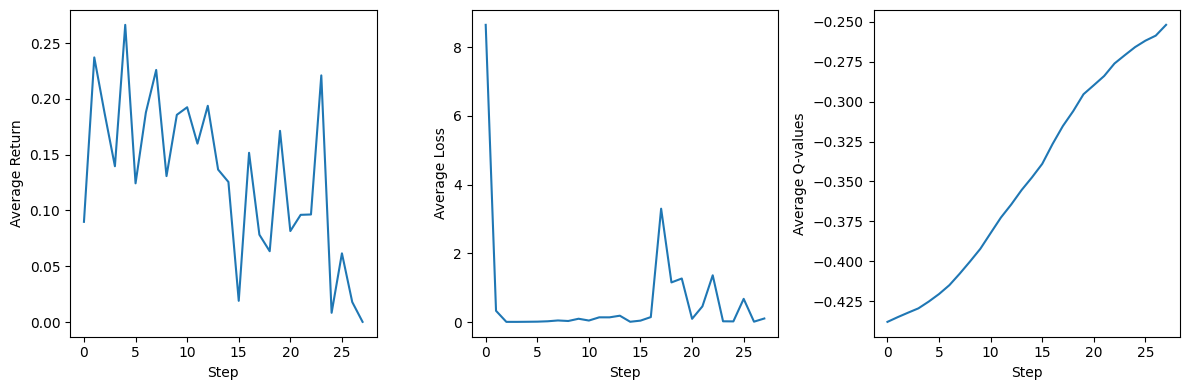

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

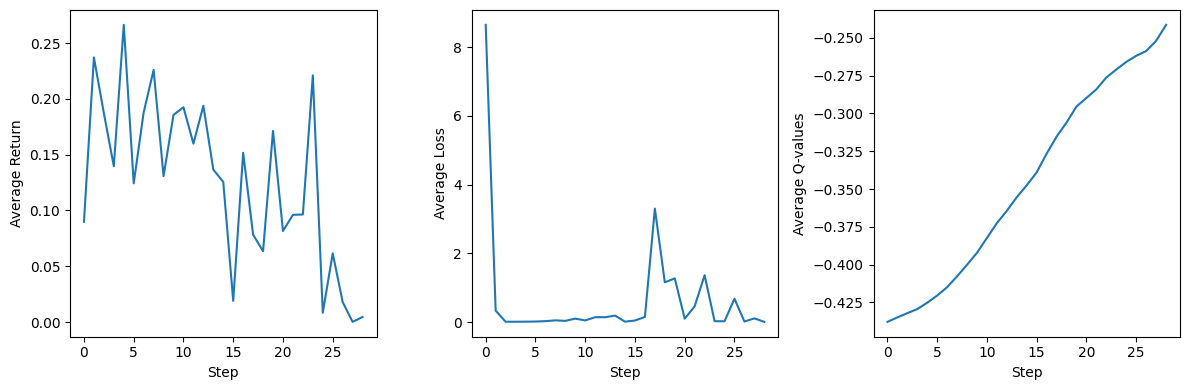

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

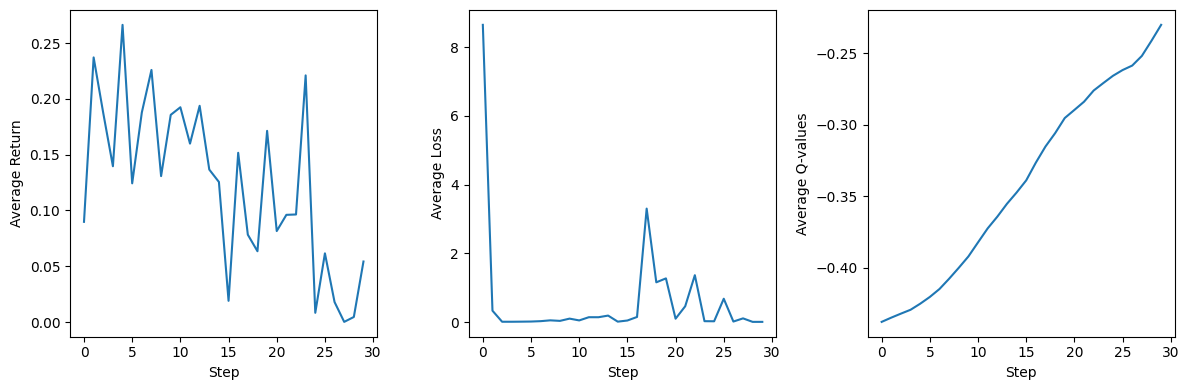

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

<Figure size 640x480 with 0 Axes>

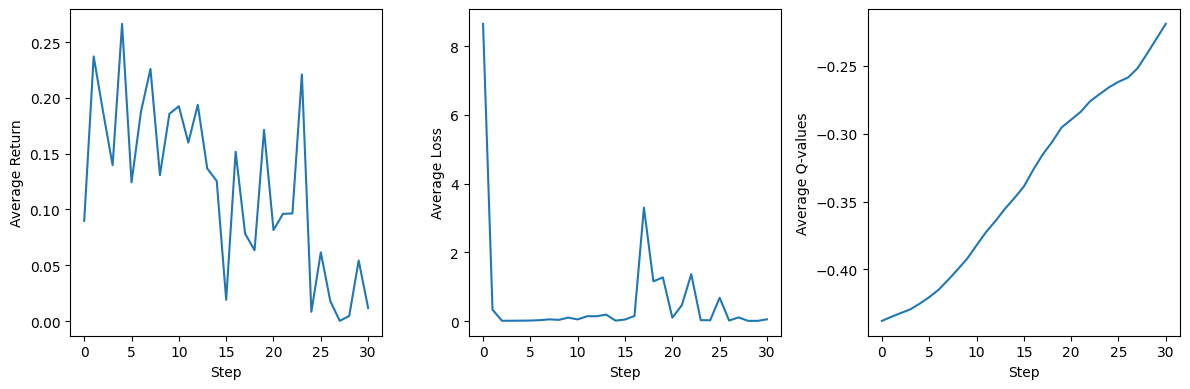

    average_return  average_loss  average_q_values  step
0         0.089818      8.644552         -0.437927     0
1         0.237099      0.333661         -0.434954     1
2         0.187156      0.012059         -0.432160     2
3         0.139610      0.011928         -0.429456     3
4         0.266275      0.014565         -0.425221     4
5         0.124292      0.018057         -0.420485     5
6         0.187764      0.029075         -0.414942     6
7         0.225863      0.052903         -0.407754     7
8         0.130776      0.037256         -0.400121     8
9         0.185649      0.102856         -0.392176     9
10        0.192446      0.050550         -0.382317    10
11        0.159881      0.143870         -0.372545    11
12        0.193763      0.143476         -0.364366    12
13        0.136630      0.191184         -0.355366    13
14        0.125520      0.014997         -0.347481    14
15        0.019047      0.047949         -0.338957    15
16        0.151659      0.15089

In [ ]:
dfs = dqn()

In [ ]:
# def test_q_network(test_dqn_network, environment_name: str, num_parallel_tests: int, gamma: float, preprocessing_function: callable, test_epsilon: float=0.05):
#     envs = gym.vector.make(environment_name, num_parallel_tests)
#     num_possible_actions = envs.single_action_space.n
#     states, _ = envs.reset()
#     done = False
#     timestep = 0
#     # episodes_finished is np vector of shape (num_parallel_tests,), filled with booleans, starting with all False
#     episodes_finished = np.zeros(num_parallel_tests, dtype=bool)
#     returns = np.zeros(num_parallel_tests)
#     test_steps = 0
#     while not done:
#         states = preprocessing_function(states)
#         q_values = test_dqn_network(states)
#         greedy_actions = tf.argmax(q_values, axis=1) # tensor of type tf.int64, shape (num_parallel_tests,)
#         random_actions = tf.random.uniform(shape=(num_parallel_tests, ), minval=0,
#                                            maxval=num_possible_actions, dtype=tf.int64)
#         epsilon_sampling = tf.random.uniform(shape=(num_parallel_tests,), minval=0,
#                                              maxval=1, dtype=tf.float32) > test_epsilon # tensor of type tf.bool, shape (num_parallel_tests,)
#         actions = tf.where(epsilon_sampling, greedy_actions, random_actions).numpy() # tensor of type tf.int64, shape (num_parallel_tests,)
#         states, rewards, terminateds, _, _ = envs.step(actions)
#         # compute pointwise or between episodes_finished and terminateds
#         episodes_finished = np.logical_or(episodes_finished, terminateds)
#         returns += ((gamma**timestep)*rewards)*(np.logical_not(episodes_finished).astype(np.float32))
#         timestep += 1
#         # done if all episodes are finished
#         done = np.all(episodes_finished)
#         test_steps += 1
#         # if test_steps % 100 == 0:
#         #    print(f"test_steps: {test_steps} {np.sum(episodes_finished)/num_parallel_tests} {terminateds.shape} {episodes_finished.shape}")
#     return np.mean(returns)

In [ ]:
# def train_dqn(train_dqn_network, target_network, dataset, optimizer, gamma: float, num_training_steps: int, batch_size: int=256):
#     dataset = dataset.batch(batch_size).prefetch(4)
#     @tf.function
#     def training_step(q_target, observations, actions):
#         with tf.GradientTape() as tape:
#             q_predictions_all_actions = target_network(observations) # shape of q_predictions is (batch_size, num_actions)
#             q_predictions = tf.gather(q_predictions_all_actions, actions, batch_dims=1)
#             loss = tf.reduce_mean(tf.square(q_predictions - q_target))
#         gradients = tape.gradient(loss, train_dqn_network.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, train_dqn_network.trainable_variables))
#         return loss

#     losses = []
#     q_values = []
#     for i, state_transition in enumerate(dataset):
#         state, action, reward, subsequent_state, terminated = state_transition
#         # calculate q_target and get arg max with target network
#         q_vals = target_network(subsequent_state)
#         q_values.append(tf.reduce_mean(q_vals).numpy())
#         max_q_values = tf.reduce_max(q_vals, axis=1)
#         use_subsequent_state = tf.where(terminated, tf.zeros_like(max_q_values, dtype=tf.float32), tf.ones_like(max_q_values, dtype=tf.float32))
#         q_target = reward + (gamma*max_q_values*use_subsequent_state)
#         loss = training_step(q_target, observations=state, actions=action).numpy()
#         losses.append(loss)
#         if i >= num_training_steps:
#             break

#     return np.mean(losses), np.mean(q_values)